Setting Library

In [1]:
#Data Prrocessing
import pandas as pd
import datetime as dt
import numpy as np

#API
import vnstock
from vnstock import *

#Visualization
import matplotlib.pyplot as plt

#Predictions
import tensorflow as tf
tf.config.list_physical_devices('GPU') #GPU device
from sklearn.preprocessing import MinMaxScaler
from keras.models import Sequential
from keras.layers import Dense, Dropout, LSTM
from keras import optimizers

Load data

In [2]:
#Company list
companies = []
fhandle = open("Data\companylist.txt","r")
order = 0
for line in fhandle.readlines():
    company = line.strip()
    order += 1
    print(f"{order}.{company}'s stock")

1.FPT's stock
2.CTG's stock
3.LCG's stock
4.HAG's stock


In [3]:
company = 'FPT'
df = pd.read_csv(f"Data\Raw\{company}.csv", delimiter = ",", encoding="utf-8")
df

,Unnamed: 0,Open,High,Low,Close,Volume,TradingDate
0,0,15710.0,15710.0,15710.0,15710.0,83530,2006-12-13
1,1,16495.0,16495.0,16495.0,16495.0,280710,2006-12-14
2,2,17320.0,17320.0,17320.0,17320.0,265300,2006-12-15
3,3,18184.0,18184.0,18184.0,18184.0,215790,2006-12-18
4,4,19087.0,19087.0,19087.0,19087.0,137520,2006-12-19
...,...,...,...,...,...,...,...
4016,4016,84200.0,84400.0,83700.0,83700.0,893299,2023-01-30
4017,4017,83500.0,83700.0,81700.0,83500.0,1531495,2023-01-31
4018,4018,84000.0,84000.0,81800.0,82000.0,1051061,2023-02-01
4019,4019,82100.0,82400.0,81300.0,81900.0,1327690,2023-02-02


Preprocessing data

In [4]:
#Format data
df['TradingDate'] = pd.to_datetime(df.TradingDate, format = "%Y/%m/%d")

In [5]:
#* Candlesticks
#* Median
#* var
#* SMV
#* SD
#* sem
#* RSI 


#Candlesticks
df['H-L'] = df['High'] - df['Low']
df['O-C'] = df['Open'] - df['Close']

#Labels
MA1 = 7
MA2 = 14
MA3 = 21
MA4 = 28

df['AR'] = df['H-L']/df['O-C']
#Median
df[f'ME_{MA1}'] = df['Close'].rolling(window = MA1).median()
df[f'ME_{MA2}'] = df['Close'].rolling(window = MA2).median()
df[f'ME_{MA3}'] = df['Close'].rolling(window = MA3).median()
df[f'ME_{MA4}'] = df['Close'].rolling(window = MA4).median()
#Rank 
df[f'RANK_{MA1}'] = df['Close'].rolling(window = MA1).rank()
df[f'RANK_{MA2}'] = df['Close'].rolling(window = MA2).rank()
df[f'RANK_{MA3}'] = df['Close'].rolling(window = MA3).rank()
df[f'RANK_{MA4}'] = df['Close'].rolling(window = MA4).rank()

#Var
df[f'VAR_{MA1}'] = df['Close'].rolling(window = MA1).var()
df[f'VAR_{MA2}'] = df['Close'].rolling(window = MA2).var()
df[f'VAR_{MA3}'] = df['Close'].rolling(window = MA3).var()
df[f'VAR_{MA4}'] = df['Close'].rolling(window = MA4).var()

#Simple moving average
df[f'SMA_{MA1}'] = df['Close'].rolling(window = MA1).mean()
df[f'SMA_{MA2}'] = df['Close'].rolling(window = MA2).mean()
df[f'SMA_{MA3}'] = df['Close'].rolling(window = MA3).mean()
df[f'SMA_{MA4}'] = df['Close'].rolling(window = MA4).mean()

#Standard deviation
df[f'SD_{MA1}'] = df['Close'].rolling(window = MA1).std()
df[f'SD_{MA2}'] = df['Close'].rolling(window = MA2).std()
df[f'SD_{MA3}'] = df['Close'].rolling(window = MA3).std()
df[f'SD_{MA4}'] = df['Close'].rolling(window = MA4).std()

#Skewness
df[f'Ske_{MA1}'] = df['Close'].rolling(window = MA1).skew()
df[f'Ske_{MA2}'] = df['Close'].rolling(window = MA2).skew()
df[f'Ske_{MA3}'] = df['Close'].rolling(window = MA3).skew()
df[f'Ske_{MA4}'] = df['Close'].rolling(window = MA4).skew()

#Kurtosis
df[f'Kur_{MA1}'] = df['Close'].rolling(window = MA1).kurt()
df[f'Kur_{MA2}'] = df['Close'].rolling(window = MA2).kurt()
df[f'Kur_{MA3}'] = df['Close'].rolling(window = MA3).kurt()
df[f'Kur_{MA4}'] = df['Close'].rolling(window = MA4).kurt()

df[df.replace([np.inf, -np.inf], np.nan).notnull().all(axis = 1)]
#Drop missing data
df.dropna(inplace = True)


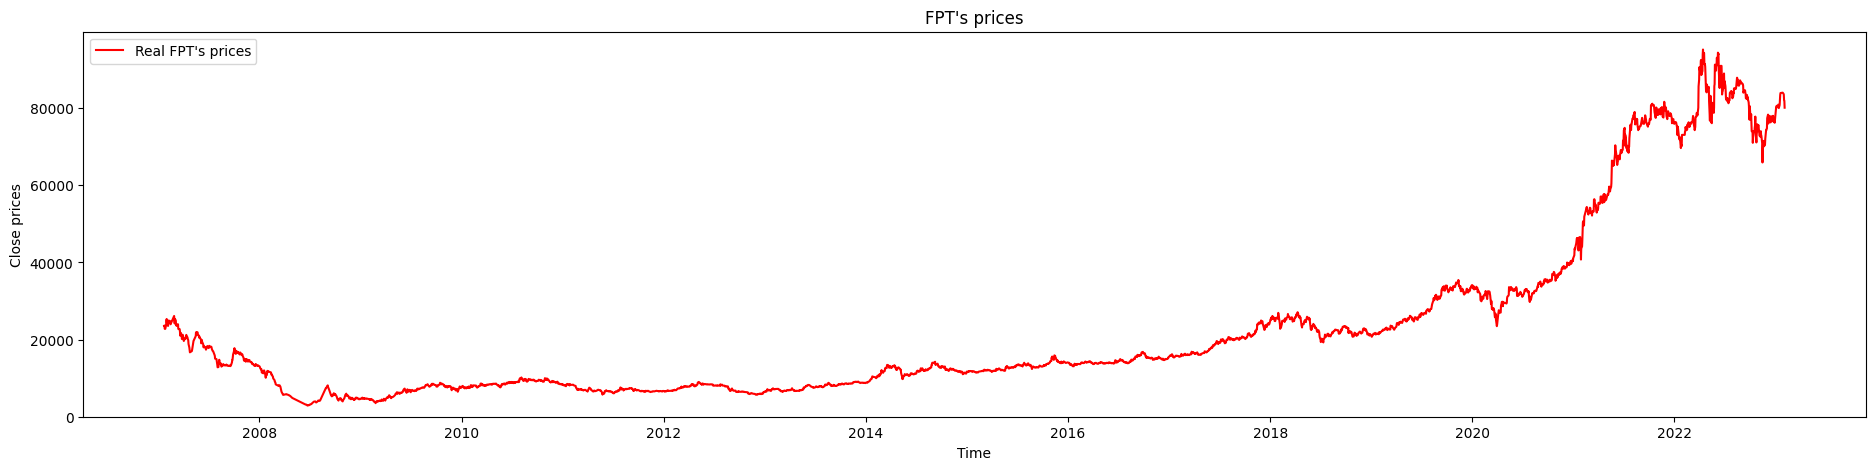

In [6]:
#Visualization
real_price = pd.DataFrame(df, columns = ['TradingDate', 'Close'])
real_price.index = real_price.TradingDate
real_price.drop('TradingDate', axis = 1, inplace = True)
plt.figure(figsize = (23,5))
plt.plot(real_price['Close'], color = "red", label = f"Real {company}'s prices")
plt.title(f"{company}'s prices")
plt.xlabel("Time")
plt.ylabel("Close prices")
plt.ylim(bottom = 0)
plt.legend() #Notices
plt.show()

In [7]:
#Exporting data
df.to_csv(f"Data\Prepaired\{company}pre.csv", encoding = "utf-8")

Processing Data

In [8]:
#Set domain
scaler_x = MinMaxScaler(feature_range = (0, 1))
scaler_y = MinMaxScaler(feature_range = (0, 1))

In [9]:
#Fit data
cols_x = ['Close','H-L', 'O-C', 'Volume', f'ME_{MA1}', f'ME_{MA2}', f'ME_{MA3}', f'ME_{MA4}', f'VAR_{MA1}', f'VAR_{MA2}', f'VAR_{MA3}', f'VAR_{MA4}', f'RANK_{MA1}', f'RANK_{MA2}', f'RANK_{MA3}', f'RANK_{MA4}', f'SMA_{MA1}', f'SMA_{MA2}', f'SMA_{MA3}', f'SMA_{MA4}', f'SD_{MA1}' ,f'SD_{MA2}', f'SD_{MA3}', f'SD_{MA4}', f'Ske_{MA1}', f'Ske_{MA2}', f'Ske_{MA3}', f'Ske_{MA4}', f'Kur_{MA1}', f'Kur_{MA2}', f'Kur_{MA3}', f'Kur_{MA4}',] #Variables for training
cols_y = ['Close','H-L', 'O-C', 'Volume', f'ME_{MA1}', f'ME_{MA2}', f'ME_{MA3}', f'ME_{MA4}', f'VAR_{MA1}', f'VAR_{MA2}', f'VAR_{MA3}', f'VAR_{MA4}', f'RANK_{MA1}', f'RANK_{MA2}', f'RANK_{MA3}', f'RANK_{MA4}', f'SMA_{MA1}', f'SMA_{MA2}', f'SMA_{MA3}', f'SMA_{MA4}', f'SD_{MA1}' ,f'SD_{MA2}', f'SD_{MA3}', f'SD_{MA4}', f'Ske_{MA1}', f'Ske_{MA2}', f'Ske_{MA3}', f'Ske_{MA4}', f'Kur_{MA1}', f'Kur_{MA2}', f'Kur_{MA3}', f'Kur_{MA4}',]
scaled_data_x = scaler_x.fit_transform(df[cols_x].values.reshape(-1, len(cols_x))) 
scaled_data_y = scaler_y.fit_transform(df[cols_y].values.reshape(-1, len(cols_y)))

In [10]:
df.head()

,Unnamed: 0,Open,High,Low,Close,Volume,TradingDate,H-L,O-C,AR,...,SD_21,SD_28,Ske_7,Ske_14,Ske_21,Ske_28,Kur_7,Kur_14,Kur_21,Kur_28
27,27,23800.0,23800.0,23565.0,23565.0,461630,2007-01-22,235.0,235.0,1.000000,...,1903.624480,1950.290020,0.145941,0.182081,0.608849,0.517366,-0.343834,-1.066292,-0.750227,-0.194885
28,28,23565.0,23643.0,23565.0,23643.0,243990,2007-01-23,78.0,-78.0,-1.000000,...,2047.254152,1987.741358,0.239772,0.218264,0.476427,0.677435,-1.951041,-1.449329,-0.994664,-0.441285
29,29,23643.0,23643.0,22779.0,22779.0,156420,2007-01-24,864.0,864.0,1.000000,...,2030.326956,1982.771449,-0.248886,0.010061,0.338480,0.633136,-1.180355,-1.620373,-1.259087,-0.788737
31,31,22387.0,23133.0,22387.0,22779.0,129240,2007-01-26,746.0,-392.0,-1.903061,...,2059.179942,2033.907170,-0.670639,-0.607652,-0.058517,0.354105,1.269831,-0.946771,-1.450627,-1.251390
32,32,22976.0,23761.0,22976.0,23761.0,201310,2007-01-29,785.0,-785.0,-1.000000,...,2121.331749,2132.775975,0.415947,-0.786168,-0.213655,0.252127,-2.581091,-0.320735,-1.392331,-1.377305


In [11]:
#Training seq X and output value Y
pre_day = 90
x_total = [] # Variables today
y_total = [] #Close price tomorrow
for i in range(pre_day, len(df)):
    x_total.append(scaled_data_x[i - pre_day : i])
    y_total.append(scaled_data_y[i])

In [12]:
#Set test
test_size = 60

#Traning set
x_train = np.array(x_total[:len(x_total)-test_size]) #tranning set (0, 30)
y_train = np.array(y_total[:len(y_total)-test_size]) #taget tranning set

#Predicted set
x_test = np.array(x_total[len(x_total)-test_size:]) #predicted set (31,...)
y_test = np.array(y_total[len(y_total)-test_size:]) #taget predicted set

#Structure of tranning data
print(x_train.shape, y_train.shape, x_test.shape, y_test.shape)

(3701, 90, 32) (3701, 32) (60, 90, 32) (60, 32)


Build Model

In [13]:
#Layers
model = Sequential()
cells = 180
model.add(LSTM(units = cells, return_sequences = True, activation='tanh', recurrent_activation='sigmoid', input_shape = (90, 32))) #input traning date and predicting date 
model.add(Dropout(0.1))
model.add(LSTM(units = cells))
model.add(Dropout(0.1))
model.add(Dense(units = len(cols_y)))

In [14]:
#Config tranning
#optimizer=optimizers.RMSprop()
model.compile(optimizer = optimizers.RMSprop(), loss = 'mse', metrics = ['accuracy']) #Optimizer, loss
history = model.fit(x_train, y_train, epochs = 1, batch_size = 1, use_multiprocessing = True, validation_split=0.2, shuffle=True)#Fit input to taget

2960/2960 [==============================] - 74s 24ms/step - loss: 0.0115 - accuracy: 0.4125 - val_loss: 0.0245 - val_accuracy: 0.3198


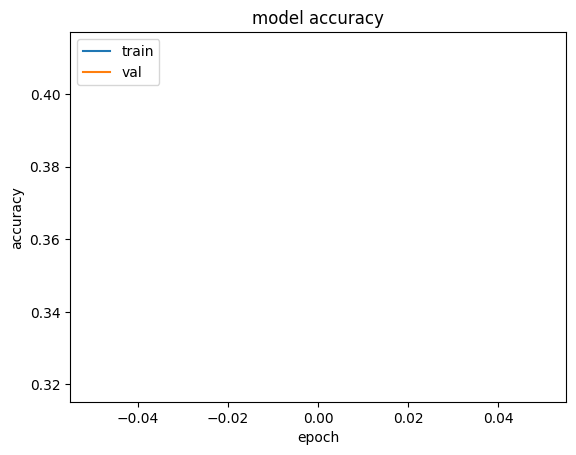

In [15]:
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.show()

2/2 [==============================] - 0s 29ms/step


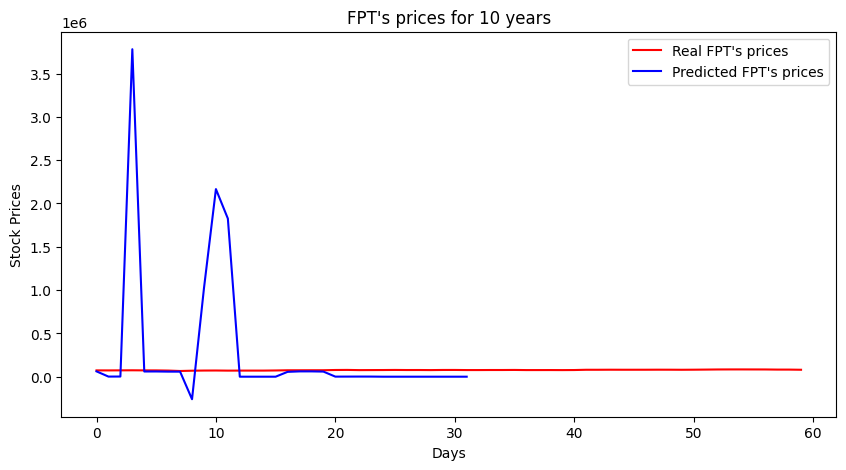

In [20]:
#Config real price
real_price = df[len(df)-test_size:]['Close'].values.reshape(-1, 1)
real_price = np.array(real_price)
real_price = real_price.reshape(real_price.shape[0], 1)

#Config predicted price
predict_prices = model.predict(x_test)
predict_prices = scaler_y.inverse_transform(predict_prices)

#Predicted days
plt.figure(figsize = (10,5))
plt.plot(real_price, color = "red", label = f"Real {company}'s prices")
plt.plot(predict_prices[0], color = "blue", label = f"Predicted {company}'s prices")
plt.title(f"{company}'s prices for 10 years")
plt.xlabel("Days")
plt.ylabel("Stock Prices")
plt.legend()
plt.show()

In [17]:
#Save model
from keras.models import save_model

save_model(model, f"Model\{company}.h5", include_optimizer = True)

# Deploy product

Load model

[[[0.86151112 0.114026   0.64592769 ... 0.14028951 0.04124704 0.04053463]
  [0.85175915 0.19456909 0.59395649 ... 0.09455005 0.05695457 0.04556681]
  [0.84092362 0.17155678 0.70532334 ... 0.15647323 0.08848986 0.06567127]
  ...
  [0.85717691 0.25209987 0.74244562 ... 0.02432317 0.09845655 0.03938956]
  [0.85609336 0.12553216 0.60880541 ... 0.03197337 0.13323512 0.03766863]
  [0.83658941 0.21758141 0.73502116 ... 0.03286531 0.17386897 0.04541802]]]
1/1 [==============================] - 0s 24ms/step


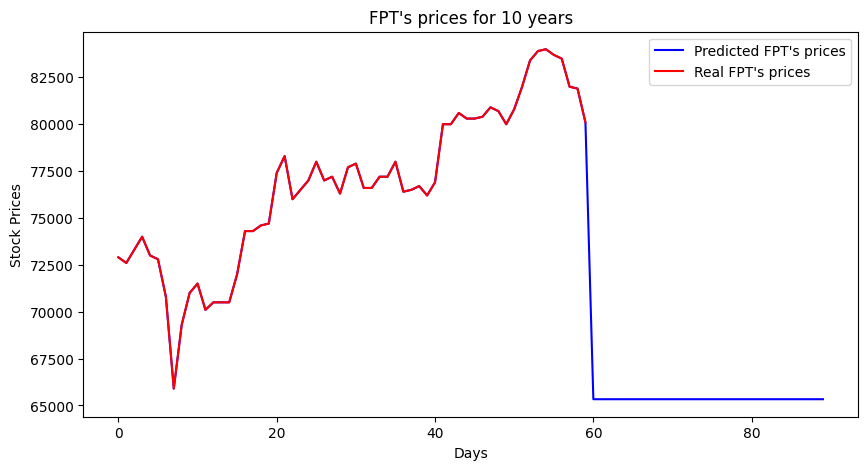

In [19]:
#Load model
from keras.models import load_model

def Scaler():
    scaler_x = MinMaxScaler(feature_range = (0, 1))
    scaler_y = MinMaxScaler(feature_range = (0, 1))
    cols_x = ['Close','H-L', 'O-C', 'Volume', f'ME_{MA1}', f'ME_{MA2}', f'ME_{MA3}', f'ME_{MA4}', f'VAR_{MA1}', f'VAR_{MA2}', f'VAR_{MA3}', f'VAR_{MA4}', f'RANK_{MA1}', f'RANK_{MA2}', f'RANK_{MA3}', f'RANK_{MA4}', f'SMA_{MA1}', f'SMA_{MA2}', f'SMA_{MA3}', f'SMA_{MA4}', f'SD_{MA1}' ,f'SD_{MA2}', f'SD_{MA3}', f'SD_{MA4}', f'Ske_{MA1}', f'Ske_{MA2}', f'Ske_{MA3}', f'Ske_{MA4}', f'Kur_{MA1}', f'Kur_{MA2}', f'Kur_{MA3}', f'Kur_{MA4}',] #Variables for training
    cols_y = ['Close','H-L', 'O-C', 'Volume', f'ME_{MA1}', f'ME_{MA2}', f'ME_{MA3}', f'ME_{MA4}', f'VAR_{MA1}', f'VAR_{MA2}', f'VAR_{MA3}', f'VAR_{MA4}', f'RANK_{MA1}', f'RANK_{MA2}', f'RANK_{MA3}', f'RANK_{MA4}', f'SMA_{MA1}', f'SMA_{MA2}', f'SMA_{MA3}', f'SMA_{MA4}', f'SD_{MA1}' ,f'SD_{MA2}', f'SD_{MA3}', f'SD_{MA4}', f'Ske_{MA1}', f'Ske_{MA2}', f'Ske_{MA3}', f'Ske_{MA4}', f'Kur_{MA1}', f'Kur_{MA2}', f'Kur_{MA3}', f'Kur_{MA4}',]
    scaled_data_x = scaler_x.fit_transform(df[cols_x].values.reshape(-1, len(cols_x))) 
    scaled_data_y = scaler_y.fit_transform(df[cols_y].values.reshape(-1, len(cols_y)))
    return cols_x, scaled_data_x, scaled_data_y

def Load_Model():
    model = Sequential()
    cells = 180
    model.add(LSTM(units = cells, return_sequences = True, activation='tanh', recurrent_activation='sigmoid', input_shape = (90, 32))) #input traning date and predicting date 
    model.add(Dropout(0.1))
    model.add(LSTM(units = cells))
    model.add(Dropout(0.1))
    model.add(Dense(units = len(cols_y)))
    model = load_model(f"Model\{company}.h5")
    return model
    
def Visualize(df, model):
    real_prices = df[len(df)-30:]['Close'].values.reshape(-1, 1)
    real_prices = np.array(real_price)
    real_prices = real_price.reshape(real_price.shape[0], 1)
    predict_prices = real_price
    x_predict = df[len(df)-90:][cols_x].values.reshape(-1, len(cols_x))
    x_predict = scaler_x.transform(x_predict)
    x_predict = np.array(x_predict)
    x_predict = x_predict.reshape(1, x_predict.shape[0], len(cols_x))
    print(x_predict)
    for i in range(30):
        prediction = model.predict(x_predict)
        prediction = scaler_y.inverse_transform(prediction)
        predict_prices = np.append(predict_prices, prediction[0][0])
        for i in range(30):
            x_predict[0][i] = x_predict[0][i + 1]
        prediction = scaler_x.transform(prediction)
        x_predict[0][30] = prediction
    plt.figure(figsize=(10, 5))
    plt.plot(predict_prices, color="blue", label=f"Predicted {company}'s prices")
    plt.plot(real_prices, color="red", label=f"Real {company}'s prices")
    plt.title(f"{company}'s prices for 10 years")
    plt.xlabel("Days")
    plt.ylabel("Stock Prices")
    plt.legend()
    plt.show()
    
Visualize(df, Load_Model())

